In [1]:
import glob
import warnings
import pandas as pd
import numpy as np
import astropy.units as u
from matplotlib import pyplot, colors
from astropy.coordinates import SkyCoord
from astropy.coordinates.builtin_frames import SkyOffsetFrame
from gammapy.stats import WStatCountsStatistic
from utils import calc_offset_rotation

In [2]:
pyplot.rcParams['figure.figsize'] = (12, 9)
pyplot.rcParams['font.size'] = 15
pyplot.rcParams['grid.linestyle'] = ':'

color_cycle = pyplot.rcParams['axes.prop_cycle'].by_key()['color']
warnings.simplefilter('ignore')

# Load DL2 data

In [3]:
data_path = '/home/yoshiki.ohtani/combined_analysis/real/CrabNebula/2020_11_18/4.dl1_to_dl2/data/dl2/merged/*.h5'

paths_list = glob.glob(data_path)
paths_list.sort()

obs_time = 0
data_stereo = pd.DataFrame()

print('Loading the following data files:')

for path in paths_list:
    
    print(path.split('/')[-1])
    
    df_obs = pd.read_hdf(path, key='events/params')
    
    timestamps = df_obs.query('tel_id == 1')['dragon_time'].values
    
    obs_time += (timestamps[-1] - timestamps[0]) * u.s
    data_stereo = data_stereo.append(df_obs)
    
data_stereo.sort_index(inplace=True)

for tel_id, tel_name in zip([1, 2, 3], ['LST-1', 'MAGIC-I', 'MAGIC-II']):
    n_events = len(data_stereo.query(f'tel_id == {tel_id}'))
    print(f'{tel_name}: {n_events} events')
    
print(f'\nobservation time = {obs_time.to(u.min).value:.1f} [min]')

Loading the following data files:
dl2_lst1_magic_Run02923.h5
dl2_lst1_magic_Run02924.h5
LST-1: 262467 events
MAGIC-I: 262467 events
MAGIC-II: 262467 events

observation time = 36.6 [min]


In [4]:
data_stereo.head(3)

obs_id_lst  event_id_lst   intensity         x  \
obs_id  event_id tel_id                                                   
5093174 2130     1           2923.0     2054693.0  646.928410 -0.682803   
                 2           2923.0     2054693.0  309.348958 -0.267904   
                 3           2923.0     2054693.0  268.299479 -0.314013   

                                y         r         phi    length     width  \
obs_id  event_id tel_id                                                       
5093174 2130     1       0.063893  0.685786  174.654160  0.138337  0.056016   
                 2       0.084833  0.281014  162.429424  0.044108  0.027682   
                 3       0.010559  0.314191  178.074182  0.054217  0.025034   

                               psi  ...  az_reco_mean  alt_reco_mean  \
obs_id  event_id tel_id             ...                                
5093174 2130     1       39.110881  ...      1.527529        0.77114   
                 2       80.681458  ...      1.527529        0.77114   
                 3       71.841862  ...      1.527529        0.77114   

                            ra_tel    dec_tel  ra_reco_mean  dec_reco_mean  \
obs_id  event_id tel_id                                                      
5093174 2130     1       83.963122  22.247059     84.446739      21.245125   
                 2             NaN        NaN     84.446739      21.245125   
                 3             NaN        NaN     84.446739      21.245125   

                         event_class_0  event_class_1  event_class_0_mean  \
obs_id  event_id tel_id                                                     
5093174 2130     1            0.395065       0.604935            0.672623   
                 2            0.775038       0.224962            0.672623   
                 3            0.847765       0.152235            0.672623   

                         event_class_1_mean  
obs_id  event_id tel_id                      
5093174 2130     1                 0.327377  
                 2                 0.327377  
                 3                 0.327377  

[3 rows x 64 columns]

In [5]:
data_stereo.tail(3)

obs_id_lst  event_id_lst   intensity         x  \
obs_id  event_id tel_id                                                   
5093175 329182   1           2924.0    14698279.0  365.777996 -0.697967   
                 2           2924.0    14698279.0   67.312500  0.025807   
                 3           2924.0    14698279.0  568.332031 -0.167793   

                                y         r         phi    length     width  \
obs_id  event_id tel_id                                                       
5093175 329182   1      -0.309413  0.763475 -156.092023  0.102070  0.051255   
                 2       0.022027  0.033930   40.481815  0.027375  0.013803   
                 3      -0.318894  0.360344 -117.752111  0.076178  0.054876   

                               psi  ...  az_reco_mean  alt_reco_mean  \
obs_id  event_id tel_id             ...                                
5093175 329182   1      -22.056541  ...      1.585434       0.939514   
                 2       56.810525  ...      1.585434       0.939514   
                 3       19.367030  ...      1.585434       0.939514   

                            ra_tel    dec_tel  ra_reco_mean  dec_reco_mean  \
obs_id  event_id tel_id                                                      
5093175 329182   1       83.265238  21.788362     83.927661      22.374704   
                 2             NaN        NaN     83.927661      22.374704   
                 3             NaN        NaN     83.927661      22.374704   

                         event_class_0  event_class_1  event_class_0_mean  \
obs_id  event_id tel_id                                                     
5093175 329182   1            0.009194       0.990806            0.017455   
                 2            0.027970       0.972030            0.017455   
                 3            0.015202       0.984798            0.017455   

                         event_class_1_mean  
obs_id  event_id tel_id                      
5093175 329182   1                 0.982545  
                 2                 0.982545  
                 3                 0.982545  

[3 rows x 64 columns]

# Event selection

In [6]:
quality_cuts = {
    1: '(intensity > 50) & (ra_tel > 0) & (intensity_width_2 < 0.15)',
    2: '(intensity > 50) & (intensity_width_2 < 0.15)',
    3: '(intensity > 50) & (intensity_width_2 < 0.15)'
}

data_stereo_cut = pd.DataFrame()

print(f'Applying the parameter cuts:\n{quality_cuts}\n')

for tel_id in quality_cuts.keys():
    
    df_tel = data_stereo.query(f'(tel_id == {tel_id}) & {quality_cuts[tel_id]}')
    data_stereo_cut = data_stereo_cut.append(df_tel)
    
# --- apply the multiplicity cut ---
data_stereo_cut.sort_index(inplace=True)
data_stereo_cut['multiplicity'] = data_stereo_cut.groupby(['obs_id', 'event_id']).size()
data_stereo_cut = data_stereo_cut.query('multiplicity == 3')
data_stereo_cut = data_stereo_cut.drop('multiplicity', axis=1)

for tel_id, tel_name in zip([1, 2, 3], ['LST-1', 'MAGIC-I', 'MAGIC-II']):
    n_events = len(data_stereo_cut.query(f'tel_id == {tel_id}'))
    print(f'{tel_name}: {n_events} events')
    
# --- make a DL2 data frame ---
df_dl2 = data_stereo_cut.groupby(['obs_id', 'event_id']).mean()
df_dl2 = df_dl2[['energy_reco_mean', 'ra_reco_mean', 'dec_reco_mean', 'event_class_0_mean']]

df_dl2['ra_tel'] = data_stereo_cut.query('tel_id == 1')['ra_tel'].values
df_dl2['dec_tel'] = data_stereo_cut.query('tel_id == 1')['dec_tel'].values

Applying the parameter cuts:
{1: '(intensity > 50) & (ra_tel > 0) & (intensity_width_2 < 0.15)', 2: '(intensity > 50) & (intensity_width_2 < 0.15)', 3: '(intensity > 50) & (intensity_width_2 < 0.15)'}

LST-1: 143013 events
MAGIC-I: 143013 events
MAGIC-II: 143013 events


In [7]:
df_dl2.head(3)

energy_reco_mean  ra_reco_mean  dec_reco_mean  \
obs_id  event_id                                                  
5093174 2130              0.466137     84.446739      21.245125   
        2132              0.801209     82.936126      22.439017   
        2134              0.185542     84.532000      22.225370   

                  event_class_0_mean     ra_tel    dec_tel  
obs_id  event_id                                            
5093174 2130                0.672623  83.963122  22.247059  
        2132                0.180159  83.963121  22.247061  
        2134                0.013661  83.963121  22.247064

In [8]:
df_dl2.tail(3)

energy_reco_mean  ra_reco_mean  dec_reco_mean  \
obs_id  event_id                                                  
5093175 329174            0.245331     82.191186      22.261292   
        329177            1.848069     81.239744      21.386079   
        329182            0.241163     83.927661      22.374704   

                  event_class_0_mean     ra_tel    dec_tel  
obs_id  event_id                                            
5093175 329174              0.008386  83.265242  21.788361  
        329177              0.063152  83.265242  21.788361  
        329182              0.017455  83.265238  21.788362

# Check count map

**Source coordinate:**

In [9]:
source_coord = SkyCoord.from_name('Crab')
source_coord = source_coord.transform_to('icrs')

print(source_coord)

<SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>


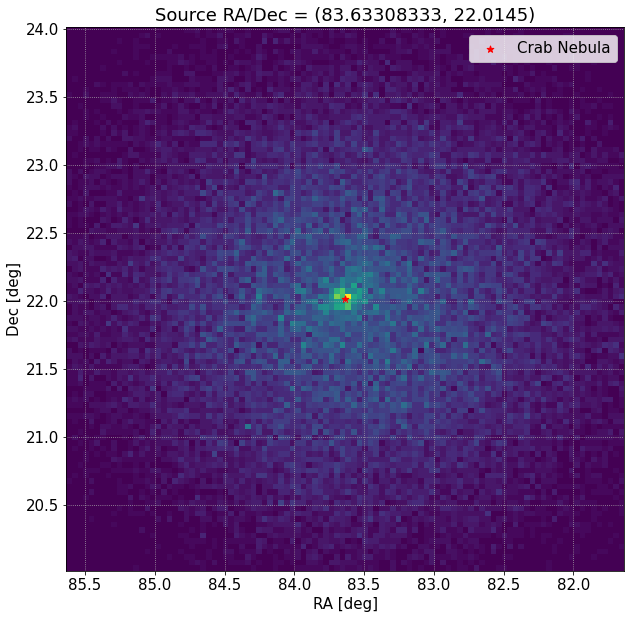

In [10]:
# --- settings ---
half_width = 2
n_bins = 101
gam_cut = 0.08

# --- main ---
ra_min = source_coord.ra.value - half_width
ra_max = source_coord.ra.value + half_width
dec_min = source_coord.dec.value - half_width
dec_max = source_coord.dec.value + half_width

bins_ra = np.linspace(ra_min, ra_max, n_bins)
bins_dec = np.linspace(dec_min, dec_max, n_bins)

pyplot.figure(figsize=(10, 10))
pyplot.title(f'Source RA/Dec = ({source_coord.ra.value}, {source_coord.dec.value})')
pyplot.xlabel('RA [deg]')
pyplot.ylabel('Dec [deg]')
pyplot.xlim(ra_min, ra_max)
pyplot.ylim(dec_min, dec_max)

pyplot.hist2d(
    df_dl2.query(f'event_class_0_mean > {gam_cut}')['ra_reco_mean'].values, 
    df_dl2.query(f'event_class_0_mean > {gam_cut}')['dec_reco_mean'].values,
    bins=[bins_ra, bins_dec]
)

pyplot.scatter(
    source_coord.ra.value, source_coord.dec.value,
    s=50, marker='*', color='red', label='Crab Nebula'
)

pyplot.axis([ra_max, ra_min, dec_min, dec_max])

pyplot.grid()
pyplot.legend()

# Calculate angular separation from source

**Event coordinates:**

In [11]:
event_coords = SkyCoord(
    ra=df_dl2['ra_reco_mean'].values*u.deg, dec=df_dl2['dec_reco_mean'].values*u.deg, frame='icrs'
)

print(event_coords)

<SkyCoord (ICRS): (ra, dec) in deg
    [(84.44673949, 21.24512525), (82.93612582, 22.4390167 ),
     (84.53199989, 22.22537031), ..., (82.19118616, 22.26129168),
     (81.23974417, 21.38607903), (83.9276612 , 22.37470388)]>


**Angular separation from the source:**

In [12]:
theta = source_coord.separation(event_coords)

df_dl2['theta2'] = theta.to(u.deg).value**2

print(f'Theta: {theta.to(u.deg)}')

Theta: [1.07889186 0.7723046  0.8590359  ... 1.35820314 2.31077777 0.45181834] deg


# Calcualte angular separation from OFF regions

**Telescope pointing coordinates:**

In [13]:
tel_coords = SkyCoord(
    ra=df_dl2['ra_tel'].values*u.deg, dec=df_dl2['dec_tel'].values*u.deg, frame='icrs'
)

print(tel_coords)

<SkyCoord (ICRS): (ra, dec) in deg
    [(83.96312171, 22.2470595 ), (83.96312139, 22.24706134),
     (83.96312086, 22.2470643 ), ..., (83.26524223, 21.78836142),
     (83.26524182, 21.78836143), (83.26523842, 21.78836153)]>


**Wobble offsets and rotation angles:**

In [14]:
offset, rotation = calc_offset_rotation(
    ra1=source_coord.ra, dec1=source_coord.dec, ra2=tel_coords.ra, dec2=tel_coords.dec
)

df_dl2['offset'] = offset.to(u.deg).value
df_dl2['rotation'] = rotation.to(u.deg).value

print(f'Woble offset: {offset}')
print(f'Rotation angle: {rotation}')

Woble offset: [0.3841229  0.38412378 0.38412518 ... 0.40941325 0.40941356 0.40941613] deg
Rotation angle: [ 37.32182206  37.32206826  37.32246407 ... 213.45949953 213.45946873
 213.45921237] deg


**Angular separation from OFF regions:**

Processing obs_id 5093174...
Processing obs_id 5093175...


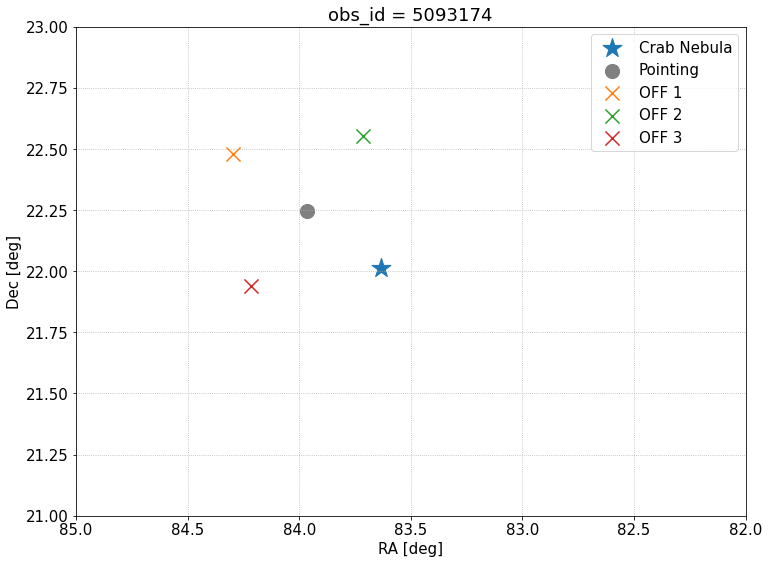

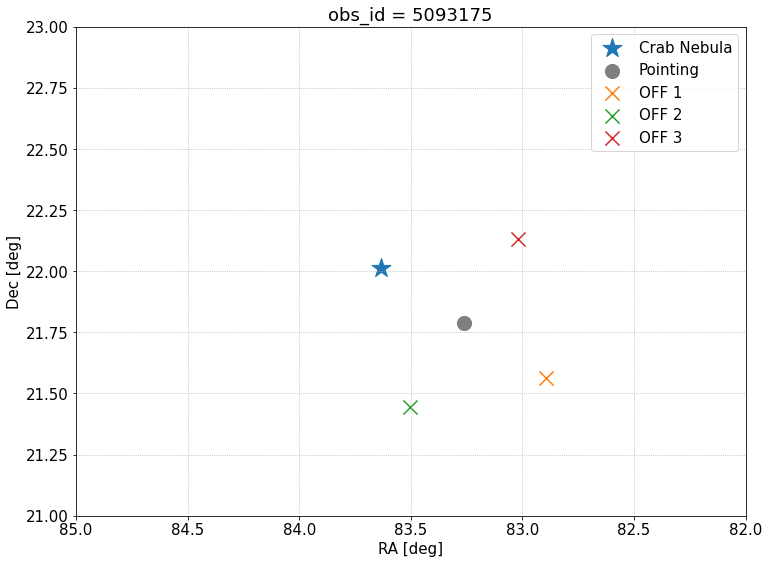

In [15]:
# --- settings ---
n_off_region = 3
xlim = (82, 85)
ylim = (21, 23)

# --- main ---
obs_ids_list = np.unique(df_dl2.index.get_level_values('obs_id'))

for obs_id in obs_ids_list:

    print(f'Processing obs_id {obs_id}...')
    
    df_obs = df_dl2.query(f'obs_id == {obs_id}')
    
    event_coords = SkyCoord(
        ra=df_obs['ra_reco_mean'].values*u.deg, dec=df_obs['dec_reco_mean'].values*u.deg, frame='icrs'
    )

    pyplot.figure()
    pyplot.title(f'obs_id = {obs_id}')
    pyplot.xlabel('RA [deg]')
    pyplot.ylabel('Dec [deg]')
    pyplot.xlim(xlim)
    pyplot.ylim(ylim)

    pyplot.axis([xlim[-1], xlim[0], ylim[0], ylim[-1]])
    
    # --- wobble coordinate ---
    mean_offset = np.mean(df_obs['offset'].values)
    mean_rot = np.mean(df_obs['rotation'].values)
    
    skyoffset_frame = SkyOffsetFrame(
        origin=source_coord, rotation=-mean_rot*u.deg
    )
    
    wobble_coord = SkyCoord(
        mean_offset*u.deg, 0*u.deg, frame=skyoffset_frame
    )
    
    wobble_coord = wobble_coord.transform_to('icrs')
    
    pyplot.scatter(
        source_coord.ra.to(u.deg).value, source_coord.dec.to(u.deg).value, 
        label='Crab Nebula', marker='*', s=400
    )
    
    pyplot.scatter(
        wobble_coord.ra.to(u.deg).value, wobble_coord.dec.to(u.deg).value, 
        label='Pointing', marker='o', s=200, color='grey'
    )
    
    # --- off region coordinates ---
    rots_list = np.arange(mean_rot, mean_rot+360, 360/(n_off_region+1))
    rots_list[rots_list > 360] -= 360
    
    diff = np.round(np.abs(rots_list - mean_rot), 0)
    rots_list = rots_list[diff != 180]
    
    for i_off, rot in enumerate(rots_list):
        
        skyoffset_frame = SkyOffsetFrame(
            origin=wobble_coord, rotation=-rot*u.deg
        )
        
        off_coord = SkyCoord(
            mean_offset*u.deg, 0*u.deg, frame=skyoffset_frame
        )
    
        off_coord = off_coord.transform_to('icrs')
        
        pyplot.scatter(
            off_coord.ra.to(u.deg).value, off_coord.dec.to(u.deg).value, 
            label=f'OFF {i_off+1}', marker='x', s=200
        )
        
        # --- angular separation from the OFF region ---
        theta = off_coord.separation(event_coords)

        df_dl2.loc[(obs_id, slice(None)), f'theta2_off{i_off+1}'] = theta.to(u.deg).value**2

    
    pyplot.legend()
    pyplot.grid()


# Check signal from source

N_on = 425

N_off_1 = 58
N_off_2 = 57
N_off_3 = 55

N_excess = 368.3
obsevation time = 36.6 [min]
--> Rate = 10.1 [1/min]

Li&Ma significance = 23.8 sigma


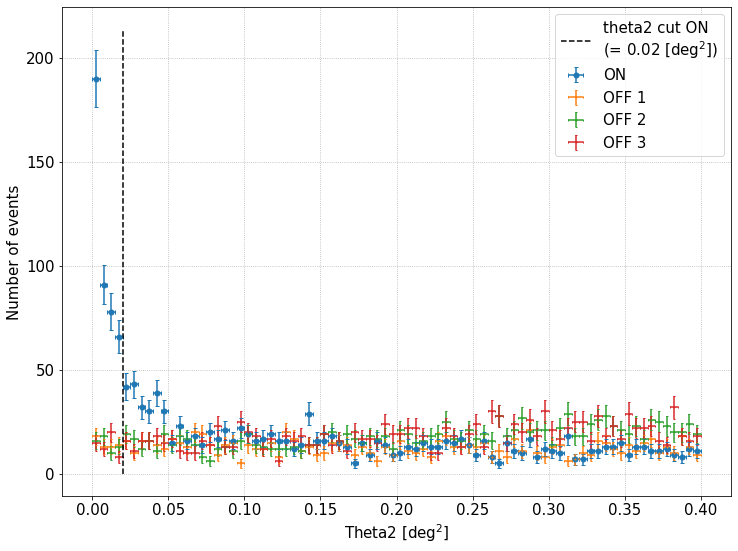

In [16]:
# --- settings ---
gam_cut = 0.8
t2_cut = 0.02
bins_t2 = np.linspace(0, 0.4, 81)

# --- check signal ---
pyplot.figure()
pyplot.xlabel('Theta2 [deg$^2$]')
pyplot.ylabel('Number of events')

df = df_dl2.query(f'event_class_0_mean > {gam_cut}')
hist_on, _ = np.histogram(df['theta2'].values, bins_t2)

bins_center = (bins_t2[:-1] + bins_t2[1:])/2

pyplot.errorbar(
    x=bins_center, xerr=[bins_center - bins_t2[:-1], bins_t2[1:] - bins_center],
    y=hist_on, yerr=np.sqrt(hist_on), 
    fmt='o', capsize=2, markersize=5, label='ON'
)

for i_off in range(n_off_region):
    
    hist_off, _ = np.histogram(df[f'theta2_off{i_off+1}'].values, bins_t2)
    
    pyplot.errorbar(
        x=bins_center, xerr=[bins_center - bins_t2[:-1], bins_t2[1:] - bins_center],
        y=hist_off, yerr=np.sqrt(hist_off), 
        fmt='o', capsize=1, markersize=1, label=f'OFF {i_off+1}'
    )
    
ylim = pyplot.ylim()

pyplot.plot(
    (t2_cut, t2_cut), (0, ylim[1]), 
    linestyle='--', color='black', label=f'theta2 cut ON\n(= {t2_cut} [deg$^2$])'
)

    
# --- calculate the significance ---
condition_on = f'(event_class_0_mean > {gam_cut}) & (theta2 < {t2_cut})'
n_events_on = len(df_dl2.query(condition_on))

print(f'N_on = {n_events_on}\n')

n_events_off = 0

for i_off in range(n_off_region):
    
    condition_off = f'(event_class_0_mean > {gam_cut}) & (theta2_off{i_off+1} < {t2_cut})'
    n_events = len(df_dl2.query(condition_off))
    
    print(f'N_off_{i_off+1} = {n_events}')
    
    n_events_off += n_events
    
alpha = 1/n_off_region
    
n_events_excess = n_events_on - n_events_off*alpha

print(f'\nN_excess = {n_events_excess:.1f}')
print(f'obsevation time = {obs_time.to(u.min).value:.1f} [min]')
print(f'--> Rate = {n_events_excess/obs_time.to(u.min).value:.1f} [1/min]')

stat = WStatCountsStatistic(n_events_on, np.sum(n_events_off), alpha=alpha)
sigma = stat.sqrt_ts
                        
print(f'\nLi&Ma significance = {sigma:.1f} sigma')
    
pyplot.grid()
pyplot.legend()